In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# read images
img0 = cv2.imread('sample data/dino0002.png', 0)
rgb0 = cv2.imread('sample data/dino0002.png')
img1 = cv2.imread('sample data/dino0001.png', 0)
rgb1 = cv2.imread('sample data/dino0001.png')

In [54]:
# get matches
def get_matches(imgL, imgR, descriptor='sift'):
    if descriptor=='surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif descriptor=='sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    else:
        raise ValueError
        
    kpL, descL = descriptor.detectAndCompute(imgL, None)
    kpR, descR = descriptor.detectAndCompute(imgR, None)
    imgL_keypoints = cv2.drawKeypoints(imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    imgR_keypoints = cv2.drawKeypoints(imgR, kpR, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descL, descR, k=2) 
    
    good_matches = []
    good_matches_without_list = []
    # ratio test
    for m,n in matches:
        if m.distance < 0.75*n.distance: # only accept matchs that are considerably better than the 2nd best match
            good_matches.append([m])
            good_matches_without_list.append(m) # this is to simplify finding a homography later

    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good_matches_without_list ])
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good_matches_without_list ])
    return src_pts, dst_pts

In [55]:
# get correspondence points
img0_pts, img1_pts = get_matches(img0, img1)

In [56]:
def normalize_coordinates(img_pts):
    n = len(img_pts)
    # compute centroid in image
    centroid_x, centroid_y = img_pts.mean(0)
    O = np.array([[1, 0, -centroid_x],
                  [0, 1, -centroid_y],
                  [0, 0, 1]])
    
    # recenter
    recentered_pts = img_pts - [centroid_x,centroid_y]
    
    # find scale term
    s = np.sqrt(2) / np.sqrt(1/n * np.sum(recentered_pts**2))
    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]])

    # transformation matrix
    T = S @ O
    
    # new coordinates
    norm_pts = np.empty(img_pts.shape)
    for idx, pt in enumerate(img_pts):
        norm_pt = T @ np.array([[pt[0]], [pt[1]], [1]])
        norm_pt = (norm_pt[:2]).squeeze()
        norm_pts[idx] = norm_pt
    return T, norm_pts #return T s.t. we can convert back later

In [57]:
T0, img0_pts_norm = normalize_coordinates(img0_pts)
T1, img1_pts_norm = normalize_coordinates(img1_pts)

In [58]:
def eight_point(src_pts, dst_pts, T0, T1):
    # 8-point algorithm
    num_match = src_pts.shape[0]
    A = np.empty((num_match, 9))
    for idx in range(num_match):
        x0, y0 = src_pts[idx]
        x1, y1 = dst_pts[idx]
        A[idx] = [x1*x0, x1*y0, x1, y1*x0, y1*y0, y1, x0, y0, 1]

    # use SVD to solve F -- take column of V corresponding to least singular value
    U,S,VT = np.linalg.svd(A)
    V = VT.T
    F = V[:,-1].reshape(3,3)

    # enforce rank 2 constraint (Tsai and Huang) -- make last eigval 0
    U,S,VT = np.linalg.svd(F)
    S[-1] = 0
    F = U@(np.diag(S))@VT

    # need to un-normalize F
    F = T1.T @ F @ T0
    return F/F[2,2]

In [59]:
F = eight_point(img0_pts_norm, img1_pts_norm, T0, T1)

In [60]:
# epiline drawing function from cv2
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [61]:
len(img1_pts)

11

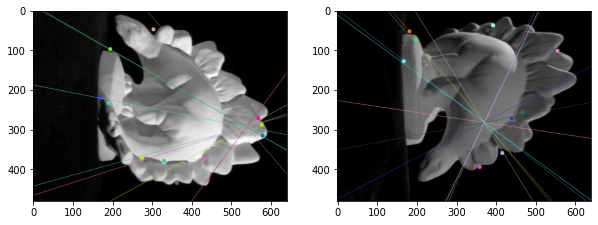

In [62]:
# epilines
# Right image
lines0 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F)
lines0 = lines0.reshape(-1,3)
img5,img6 = drawlines(img0,img1,lines0,img0_pts,img1_pts)
# Left image
lines1 = cv2.computeCorrespondEpilines(img0_pts.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img3,img4 = drawlines(img1,img0,lines1,img1_pts,img0_pts)

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img5)
plt.subplot(122)
plt.imshow(img3)
plt.show()

In [63]:
# get epipolar lines
def get_epipolar_lines(pts, F, image_num=0):
    """
    Calculates the epipolar lines
    Param:
        image_num: which image we are calculating for. If 0 --> left epiline, if 1 --> right epiline
    Returns:
        epipolar_lines: array of epipolar line coefficients [a,b,c] where 0=ax+by+cz
    """
    
    epipolar_lines = []
    for pt in pts:
        pt_x, pt_y = pt
        pt_arr = np.array([[pt_x],[pt_y],[1]])
        epipolar_line = F@pt_arr if image_num==0 else F.T@pt_arr
        a,b,c = epipolar_line
#         # normalize such that a^2 + b^2 = 1
#         k = 1/np.sqrt(a**2+b**2)
#         a, b = k*a, k*b
        epipolar_lines.append([a,b,c])
    return np.array(epipolar_lines).squeeze()

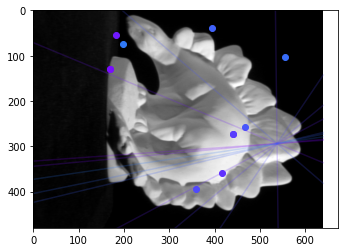

In [64]:
epipolar_lines = get_epipolar_lines(img0_pts, F, image_num=1)
height0, width0 = img0.shape
plt.imshow(img0, 'gray')
color = plt.cm.rainbow(np.linspace(0,10,width0))
for idx, epipolar_line in enumerate(epipolar_lines):
    a,b,c = epipolar_line
    x = np.linspace(0,width0,100)
    y = (a/-b)*x + (c/-b)
    plt.plot(x, y, '-r', alpha=0.2, c=color[idx])
    plt.scatter(img1_pts[idx][0], img1_pts[idx][1], color=color[idx])
plt.ylim(height0,0)
plt.show()